<a href="https://colab.research.google.com/github/ReinerJasin/Multi-Armed-Bandit/blob/main/Multi_Armed_Bandit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sample

In [ ]:
import random
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
class Bandit:
    def __init__(self, payoff_probs):
        self.actions = range(len(payoff_probs))
        self.pay_offs = payoff_probs

    def sample(self, action):
        selector = random.random()
        # we are going to keep it simple with 1 or 0 being the only rewards
        return 1 if selector <= self.pay_offs[action] else 0

In [ ]:
def initial_explore_agent(bandit, iterations, initial_rounds = 10):
    """Initially explore initial_rounds times and then stick to the best action."""
    pay_offs = dict()
    best_action = -1

    for i in range(iterations):
        # for the initial rounds pick a random action
        if i < initial_rounds:
            a = random.choice(bandit.actions)
            r = bandit.sample(a)

            #update rewards
            if a in pay_offs:
                pay_offs[a].append(r)
            else:
                pay_offs[a] = [r]
        # otherwise pick the best one thus far
        else:
            if (best_action == -1):
                # check for the action with the best average payoff
                mean_dict = {}
                for key,val in pay_offs.items():
                    mean_dict[key] = np.mean(val)
                best_action = max(mean_dict, key=mean_dict.get)
            a = best_action

            r = bandit.sample(a)

        yield a, r

In [ ]:
def epsilon_greedy_agent(bandit, iterations, epsilon = 0.2, initial_rounds = 1):
    """Use the epsilon-greedy algorithm by performing the action with the best average
    payoff with the probability (1-epsilon), otherwise pick a random action to keep
    exploring."""

    pay_offs = dict()

    for i in range(iterations):
        # sometimes randomly pick an action to explore
        if random.random() < epsilon or i < initial_rounds:
            a = random.choice(bandit.actions)
        # otherwise pick the best one thus far
        else:
            # check for the action with the best average payoff
            new_dict = {}
            for key,val in pay_offs.items():
                new_dict[key] = np.mean(val)
            a = max(new_dict, key=new_dict.get)

        r = bandit.sample(a)

        #update rewards
        if a in pay_offs:
            pay_offs[a].append(r)
        else:
            pay_offs[a] = [r]

        yield a, r

In [ ]:
def random_agent(bandit, iterations):
    """Randomly select an action and reward."""

    for i in range(iterations):
        a = random.choice(bandit.actions)
        r = bandit.sample(a)
        yield a, r

initial_explore_agent : 63.82
epsilon_greedy_agent : 73.0


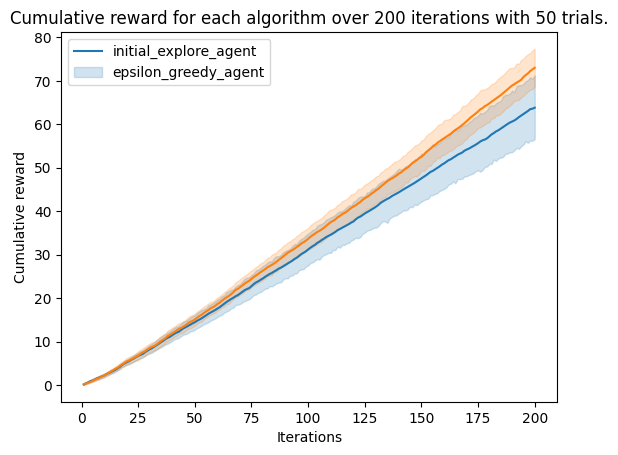

In [ ]:
pay_offs = [0.25, 0.3, 0.5, 0.1, 0.3, 0.25, 0]
bandit = Bandit(pay_offs)

# methods = [random_agent, initial_explore_agent, epsilon_greedy_agent, decaying_epsilon_greedy_agent, optimal_agent]
f = plt.figure()

methods = [initial_explore_agent, epsilon_greedy_agent]

number_of_iterations = 200
number_of_trials = 50

for m in range(len(methods)):
  method = methods[m]
  total_rewards = []

  list_of_cumulative_rewards = []
  fan = []

  for trial in range(number_of_trials):
    total_reward = 0
    cumulative_reward = []

    for a, r in method(bandit, number_of_iterations):
      total_reward += r
      cumulative_reward.append(total_reward)

    #Store the results
    total_rewards.append(total_reward)
    if trial == 0:
      fan = pd.DataFrame(cumulative_reward, columns=['y'])
      fan['x'] = fan.index+1
    else:
      fan2 = pd.DataFrame(cumulative_reward, columns=['y'])
      fan2['x'] = fan2.index+1

      fan = pd.concat([fan, fan2], ignore_index=True)

    list_of_cumulative_rewards.append(cumulative_reward)

  sns.lineplot(x='x', y='y', data=fan)  #default is to use bootstrap to calculate confidence interval

  print(method.__name__, ":", np.mean(total_rewards))

plt.title("Cumulative reward for each algorithm over {} iterations with {} trials.".format(number_of_iterations, number_of_trials))
plt.ylabel("Cumulative reward")
plt.xlabel("Iterations")
plt.legend([method.__name__ for method in methods])

f.savefig("Iterations.pdf", bbox_inches='tight')
f.savefig("Iterations.svg", bbox_inches='tight')

plt.show()

## Experimental

In [ ]:
distribution = np.random.choice(np.arange(1, 7), p=[0.2, 0.2, 0.2, 0.2, 0.1, 0.1])

In [ ]:
distribution

5

# **1. Introduction to Multi-Armed Bandit (MAB)**

The Multi-Armed Bandit (MAB) problem is a reinforcement learning problem that demonstrates AI agent decision-making ability under uncertainty. It represents the tradeoff between exploration (gathering more information) and exploitation (making the best decision based on current knowledge) to maximize rewards in the long run.


> **Real-World Analogy:**
>
>Imagine you are at a casino with multiple slot machines (each representing an "arm" in Multi Armed Bandit). Each machine provides a reward for the player, but the way machine choose the amount of reward is fully hidden from the player.
>
>Your goal is to maximize your total earnings by deciding which machine to play. If you always play the machine that seems best based on limited experience, you might miss out on an even better machine. On the other hand, if you keep testing all machines indefinitely, you may lose potential rewards.

**Applications of MAB:**
- Online Advertising -- Selecting the best ad to display to maximize click-through rate (CTR).
- A/B Testing -- Finding the most effective design, strategy, or content.
- Recommender Systems -- Choosing the best content or product for users.
- Clinical Trials -- Allocating patients to the most promising treatments.
- Dynamic Pricing -- Adjusting prices dynamically to maximize revenue.
<br><br>



---



# **2. Formal Definition of the Multi-Armed Bandit Problem**

The MAB problem can be formulated mathematically as follows:
- There are K possible actions (arms), denoted as
$A$ = {𝑎1,𝑎2,...,𝑎𝐾}.
- Each arm $a_{i}$ has an unknown reward distribution $R_{i}$.
- At each time step $t$, an agent selects an arm $a_{t}$ and receives a reward $r_{t}$.
- The objective is to maximize the cumulative reward over $T$ time steps.

**Regret in MAB:**
- Regret measures how much reward is lost by not always choosing the optimal arm.
- Cumulative regret at time $T$ is given by:
<br>
\begin{align}
R(T) = \sum_{t=1}^{T} (\mu^* - \mu_{a_t})
\end{align}
<br>
where:

  - $μ^*$ is the expected reward of the best arm.
  - $μ_{a_{t}}$ is the expected reward of the arm chosen at time $t$.

<br>
A good MAB strategy minimizes regret over time by efficiently balancing exploration and exploitation.
<br><br>



---



# **3. Exploration vs. Exploitation Tradeoff**

A key challenge in MAB is deciding between:
- Exploration -- Trying new arms to gather more information about their rewards.
- Exploitation -- Choosing the best-known arm to maximize immediate rewards.

A naive strategy that always exploits (e.g., always picking the best arm observed so far) may get stuck in a suboptimal solution. Conversely, a purely exploratory strategy wastes opportunities for higher rewards.

The goal of MAB algorithms is to find a balance between these two strategies.



---



# **4. Multi-Armed Bandit Algorithms**

There are various strategies for solving the MAB problem. Below are some of the most common ones.

# A. ϵ-Greedy Algorithm

## Import Libraries

In [ ]:
import math
import random
import numpy as np

from random import gauss

## Hyperparameter for simulation (Adjust accordingly)

In [ ]:
NUM_OF_BANDITS = 3                  # Number of bandits can be choose
EPSILON = 0.1                       # Epsilon is the probability of exploration
INITIAL_STEP = NUM_OF_BANDITS       # Initial step to give prior information to agent (min value = 1)
NUM_OF_TRIALS = 300                 # How many times the agents can take action

## Create bandit model

In [ ]:
# Bandit class represents AI Agent
class Bandit:
  def __init__(self, mean, variance):
    self.result = []
    self.mean = mean
    self.variance = variance

  # The agent choose a bandit, so the bandit regenerate number as a reward to be returned
  def random_number(self):
    rand_result = random.gauss(self.mean, math.sqrt(self.variance))
    self.result.append(rand_result)

    return rand_result

## Create bandit with randomized mean and variance

In [ ]:
# Bandit empty list
list_bandit = []

# Create a number of bandits
n_arms = NUM_OF_BANDITS

# Randomize the mean variance for each of bandits
for i in range(n_arms):
  rand_mean = random.randint(0,20)
  rand_var = random.uniform(0,10)

  # Create bandit with corresponding mean and variance
  list_bandit.append(Bandit(rand_mean, rand_var))

## (optional) Hardcoded mean and variance distribution

In [ ]:
# HARDCODED VERSION
list_bandit = [
    # Bandit(-10, 3),
    Bandit(-5, 5),
    Bandit(-1,5),
    Bandit(10,2),
    # Bandit(-3,10),
]

## Function to help us later

In [ ]:
# Count mean of bandit
# Input = item_list: list
# Output = mean: int
def count_mean(item_list):
  total = 0

  for item in item_list:
    total += item

  mean = total/len(item_list)
  return mean
  # print(mean)

# Count variance of bandit
# Input = item_list: list
# Output = variance: int
def count_variance(item_list):
  total = 0
  mean = count_mean(item_list)
  for item in item_list:
    total += math.pow(item-mean,2)

  variance = total / len(item_list)
  return variance
  # print(variance)

# FOR DEBUG ONLY
def print_all_list():
  for i, bandit in enumerate(list_bandit):
    print(f'bandit {i+1} : {bandit.result}')

## (Debug) Simulate randomized by distribution, in real case, this is hidden

In [ ]:
for bandit in list_bandit:
  for i in range(10000):
    result = bandit.random_number()
    # bandit.result.append(result)
    # print(f'Random - {i} = {result}')

# print(list_bandit[0].result)

In [ ]:
for i, bandit in enumerate(list_bandit):
  bandit_mean = count_mean(bandit.result)
  bandit_var = count_variance(bandit.result)

  print(f'BANDIT {i+1}')
  print(f'original mean = {bandit.mean}')
  print(f'counted mean = {bandit_mean}')
  print()
  print(f'original variance= {bandit.variance}')
  print(f'counted variance= {bandit_var}')
  print('====================================')

BANDIT 1
original mean = 18
counted mean = 17.97441180272735

original variance= 6.543323560022144
counted variance= 6.576845643971661
BANDIT 2
original mean = 0
counted mean = 0.003126982161977701

original variance= 4.487987105085443
counted variance= 4.448770880677415
BANDIT 3
original mean = 3
counted mean = 3.0356226825731083

original variance= 6.765813537938579
counted variance= 6.587688190695882
BANDIT 4
original mean = 4
counted mean = 3.982513263018566

original variance= 8.341555170707384
counted variance= 8.076617760731454
BANDIT 5
original mean = 8
counted mean = 8.001871361299994

original variance= 1.562882951225828
counted variance= 1.545238613163117


If the number almost match, the random is working properly

## Theory

The epsilon-greedy algorithm is one of the simplest strategies for solving the MAB problem. It works as follows:
- With probability ϵ, explore a random arm.
- With probability 1-ϵ, exploit the arm with the highest estimated reward.

Algorithm of Epsilon-Greedy:
1. Initialize the estimated values of all arms to zero or a small positive number.
2. For each trial:
*  Generate a random number between 0 and 1.
*  If the number is less than ϵ, select a random arm (exploration).
* Otherwise, select the arm with the highest estimated reward (exploitation).
* Update the estimated reward of the selected arm based on the observed reward.

## Bandit Exploration Step

In [ ]:
mean_list = np.zeros(NUM_OF_BANDITS)

# print(random.uniform(0,1))

# Initial step
for i in range(INITIAL_STEP):
  bandit_choice = np.random.randint(0,NUM_OF_BANDITS)
  # print(bandit_choice)
  result = list_bandit[bandit_choice].random_number()
  # print(result)

# print_all_list()

# E-Greedy
for i in range(NUM_OF_TRIALS):
  prob = np.random.choice([0,1], p=[EPSILON,1-EPSILON])
  if prob == 0:
    # Explore
    bandit_choice = np.random.randint(0,NUM_OF_BANDITS)
    # print("EXPLORE BANDIT ", (bandit_choice+1))
    result = list_bandit[bandit_choice].random_number()
  else:
    # Exploit
    for i, bandit in enumerate(list_bandit):
      if bandit.result:
        mean_list[i] = count_mean(bandit.result)

    # print(f'MEAN LIST = {mean_list}')
    bandit_choice = np.argmax(mean_list)
    # print(f'best bandit index to exploit: {bandit_choice}')

    # After getting the index of best bandit, we take the action
    result = list_bandit[bandit_choice].random_number()


In [ ]:
print_all_list()

for i, bandit in enumerate(list_bandit):
  if bandit.result:
    mean_list[i] = count_mean(bandit.result)

print(mean_list)

print(f'Best bandit to exploit = Bandit {np.argmax(mean_list) + 1}')

bandit 1 : [-7.926302454707799, -4.233063254729167, -7.338564660723927, -6.730852191255093, -3.591054610345484, -5.853567593622333, -2.5420145035388053, -0.7932123857906195, -4.006903003301155, -2.2193210131707835, -9.002110063319023, -4.947411747041908]
bandit 2 : [-4.659562605612859, -3.348868254743279, -3.9151947972543355, 1.3290651324462468, -5.215731733296584, 0.05762347342974472, -1.8079666573325386, 3.70516212721522, -0.8066894490676553, -0.20766474178750982]
bandit 3 : [10.362756001058907, 9.47185597512451, 11.636433114243566, 11.237608240845086, 11.169166684321342, 8.58596736975307, 8.477114350075674, 12.432469383680935, 12.811337240144162, 11.180093498497907, 9.89116918420014, 8.603159314613595, 11.274204398476897, 11.815827197909536, 10.642485584643238, 9.286073868591249, 10.915910436117144, 8.81392771795528, 12.44757909286788, 11.243331752066432, 9.042735341345544, 8.081542801644604, 12.23427987270726, 10.749303246464718, 9.187184040203137, 10.773960820621399, 10.5623656103

## DEBUG (CHECK RESULT)

In [ ]:
# DEBUG ONLY
for i, bandit in enumerate(list_bandit):
  bandit_mean = count_mean(bandit.result)
  bandit_var = count_variance(bandit.result)

  print(f'BANDIT {i+1} is rolled {len(bandit.result)} times')
  print(f'original mean = {bandit.mean}')
  print(f'counted mean = {bandit_mean}')
  print()
  print(f'original variance= {bandit.variance}')
  print(f'counted variance= {bandit_var}')
  print('====================================')

BANDIT 1 is rolled 12 times
original mean = -5
counted mean = -4.9320314567955075

original variance= 5
counted variance= 5.729271880779597
BANDIT 2 is rolled 10 times
original mean = -1
counted mean = -1.4869827506003548

original variance= 5
counted variance= 7.2808449997756854
BANDIT 3 is rolled 281 times
original mean = 10
counted mean = 10.094824196046774

original variance= 2
counted variance= 1.927478251338363


## Counting the regret index

In [ ]:
# Total reward
total_reward = 0
for i, bandit in enumerate(list_bandit):
  sum(bandit.result)
  total_reward += sum(bandit.result)

print(f'Total Rewards                = {total_reward}')

# Largest expected monetary value
total_expected_value = max(mean_list) * (NUM_OF_TRIALS + INITIAL_STEP)
print(f'Total Expected Value         = {total_expected_value}')

regret = total_expected_value - total_reward
print(f'Regret                       = {regret}')

print()
print('================================================')
print()

print(f'Rewards / step               = {total_reward / (NUM_OF_TRIALS + INITIAL_STEP)}')

print(f'Best Expected Value / step   = { max(mean_list) }')

print(f'Regret / step                = {regret / (NUM_OF_TRIALS + INITIAL_STEP)}')


Total Rewards                = 2762.591394101594
Total Expected Value         = 3058.7317314021725
Regret                       = 296.1403373005787


Rewards / step               = 9.117463346869947
Best Expected Value / step   = 10.094824196046774
Regret / step                = 0.9773608491768274


# 2. Upper Confidence Bound (UCB)

## Import Libraries

In [ ]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

## Set hyperparameters

In [ ]:
NUM_OF_BANDITS = 3
INITIAL_STEP = NUM_OF_BANDITS
NUM_OF_TRIALS = 300

## Define UCB_Bandit Model Class

UCB Bandit Model Class should have all these properties:
- **[Unobserved]** `mean` average number produced when this bandit is chosen
- **[Unobserved]** `variance` variance added to the mean when this bandit is chosen to add uncertainty to the bandit model rewards
- `number_being_selected` variable to record how many times the bandit is chosen
- `sum_of_reward` variable to record the total rewards produced by this bandit
- `ucb_value` variable to count the ucb index used for making decision in choosing bandit


In [ ]:
class UCB_Bandit:
  def __init__(self, mean, variance):
    # Hidden properties from the user
    self.mean = mean
    self.variance = variance

    self.number_being_selected = 0        # number of times the bandit is selected in total
    self.sum_of_reward = 0                # sum of rewards of the benadit
    self.ucb_value = 0

  def average_rewards(self):
    average_reward = self.sum_of_reward / self.number_being_selected

    return average_reward

  # The agent choose a bandit, so the bandit regenerate number as a reward to be returned
  def roll_a_number(self):
    rand_result = random.gauss(self.mean, math.sqrt(self.variance))

    # print(f'rolled a get number of {rand_result}')

    # Add sum of reward with the rolled number
    self.sum_of_reward += rand_result

    # Increment the number of being selected
    self.number_being_selected += 1

    self.update_ucb_value()

    return rand_result

  def update_ucb_value(self):
    self.ucb_value = self.average_rewards() + math.sqrt(2 * math.log(current_round) / self.number_being_selected)


## Create UCB bandit according to the scenario

In [ ]:
# Bandit empty list
list_bandit = []

# Randomize the mean variance for each of bandits
for i in range(NUM_OF_BANDITS):

  # rand_mean = random.randint(0,2)
  rand_mean = random.uniform(0,2)
  rand_var = random.uniform(0,1)

  # Create UCB bandit
  temp_bandit = UCB_Bandit(rand_mean, rand_var)

  # For debug only
  # print(f'bandit {i} mean      : {temp_bandit.mean}')
  # print(f'bandit {i} variance  : {temp_bandit.variance}')

  # Add each bandit to the list of bandit
  list_bandit.append(temp_bandit)

print(f"{NUM_OF_BANDITS} bandits successfully created")

3 bandits successfully created


> HARDCODED SETTING (OPTIONAL)

In [ ]:
# # HARDCODED VERSION
# list_bandit = [
#     UCB_Bandit(mean=1.2, variance=0.5),
#     UCB_Bandit(mean=0.8, variance=1.0),
#     UCB_Bandit(mean=1.5, variance=0.3),
#     UCB_Bandit(mean=1.0, variance=0.8),
#     UCB_Bandit(mean=1.3, variance=0.6),
# ]

As the initial step, we play each bandit at least once.

In [ ]:
current_round = 1
result_history = []

In [ ]:
# Loop for each bandit
for i in range(NUM_OF_BANDITS):
  rand_result = list_bandit[i].roll_a_number()
  result_history.append(rand_result)
  # print(rand_result)

  current_round += 1

Run the UCB1 Algorithm for the rest of the number of trials

In [ ]:
for i in range(NUM_OF_TRIALS - NUM_OF_BANDITS):
# for i in range(1):

  # Find bandit with the largest UCB Value
  best_bandit_ucb = np.argmax([bandit.ucb_value for bandit in list_bandit])
  # print(f'best bandit UCB: {best_bandit_ucb}')
  # print(f'best bandit UCB: {list_bandit[best_bandit_ucb].ucb_value}')

  rand_result = list_bandit[best_bandit_ucb].roll_a_number()
  result_history.append(rand_result)
  # print(rand_result)

  current_round += 1

The Upper Confidence Bound 1 Algorithm Works perfectly, now for the sake of comparison, let's make a simulation if the bandit uses 100% exploration technique.

In [ ]:
explore_results = []

for i in range(NUM_OF_TRIALS):

  # Randomize which bandit will be chosen
  rand_bandit = random.randint(0, NUM_OF_BANDITS-1)

  # Roll the bandit
  rand_result = list_bandit[rand_bandit].roll_a_number()
  explore_results.append(rand_result)

Let's see the amount of reward we got in cummulative compared to the maximum value we can earn to see the regret level.

Also we will see which one is the best bandit by looking at the parameter or bandit reward average and UCB value.

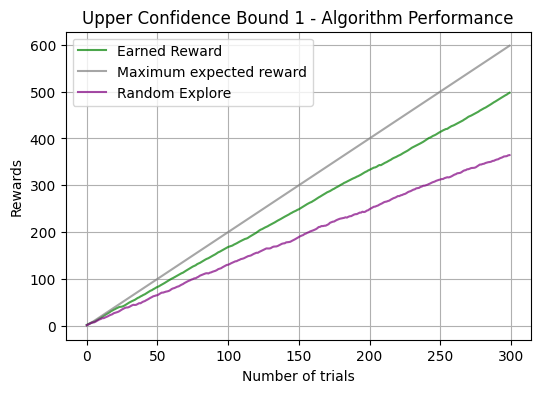

In [ ]:
# UCB1 Result
y1 = np.cumsum(result_history)

# Best possible reward
best_mean = np.argmax([bandit.mean for bandit in list_bandit])
y2 = [i*best_mean for i in range(0,current_round-1)]

# Simulated 100% Explore
y3 = np.cumsum(explore_results)

# Generate x values
x = range(len(y1))

# Plot the lines
plt.figure(figsize=(6, 4))
plt.plot(x, y1, label='Earned Reward', color='green', alpha=0.7)
plt.plot(x, y2, label='Maximum expected reward', color='grey', alpha=0.7)
plt.plot(x, y3, label='Random Explore', color='purple', alpha=0.7)

# Labels and title
plt.xlabel('Number of trials')
plt.ylabel('Rewards')
plt.title('Upper Confidence Bound 1 - Algorithm Performance')
plt.legend()
plt.grid()

# Show the plot
plt.show()

In [ ]:
print(f'Current round: {current_round}')

for i in range(NUM_OF_BANDITS):
  print(f'Sum of Reward    :{list_bandit[i].sum_of_reward}')
  print(f'Num selected     :{list_bandit[i].number_being_selected}')
  print(f'Average          :{list_bandit[i].average_rewards()}')
  print(f'UCB Value        :{list_bandit[i].ucb_value}')
  print('=================================')

print(f'bandit index to choose for next step: {np.argmax([bandit.ucb_value for bandit in list_bandit])}')
print(f'bandit index to choose for next step: {np.argmax([bandit.average_rewards() for bandit in list_bandit])}')

Current round: 301
Sum of Reward    :126.84815653476223
Num selected     :105
Average          :1.2080776812834497
UCB Value        :1.5377849183676435
Sum of Reward    :80.42864861040026
Num selected     :106
Average          :0.7587608359471723
UCB Value        :1.0869091648321123
Sum of Reward    :654.5852646002144
Num selected     :389
Average          :1.6827384694092915
UCB Value        :1.8540349061133299
bandit index to choose for next step: 2
bandit index to choose for next step: 2


Let's validate the result and see the parameter of each bandit's mean and variance.

In [ ]:
print(f'Current round: {current_round}')

for i in range(NUM_OF_BANDITS):
  print(f'bandit index-{i}')
  print(f'Sum of Reward    :{list_bandit[i].sum_of_reward}')
  print(f'Num selected     :{list_bandit[i].number_being_selected}')
  print(f'Average          :{list_bandit[i].average_rewards()}')
  print(f'UCB Value        :{list_bandit[i].ucb_value}')
  print('====================================')
  print(f'MEAN        :{list_bandit[i].mean}')
  print(f'VARIANCE    :{list_bandit[i].variance}')
  print('====================================')
  print()

print(f'largest mean bandit index: {np.argmax([bandit.mean for bandit in list_bandit])}')

Current round: 301
bandit index-0
Sum of Reward    :126.84815653476223
Num selected     :105
Average          :1.2080776812834497
UCB Value        :1.5377849183676435
MEAN        :1.1740749975821145
VARIANCE    :0.34288800898337146

bandit index-1
Sum of Reward    :80.42864861040026
Num selected     :106
Average          :0.7587608359471723
UCB Value        :1.0869091648321123
MEAN        :0.7651153718420753
VARIANCE    :0.4217111193732561

bandit index-2
Sum of Reward    :654.5852646002144
Num selected     :389
Average          :1.6827384694092915
UCB Value        :1.8540349061133299
MEAN        :1.6669021376789461
VARIANCE    :0.07965824286123213

largest mean bandit index: 2
